# NSTI Modeling preset 

In [0]:
import numpy as np
import pandas as pd # data import and maniplation 
import os 
import seaborn as sns # data visualization 
import matplotlib.pyplot as plt # data visualization 
import re
from datetime import datetime, timedelta

from sklearn import datasets, linear_model # regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # data split 

sns.set_style("whitegrid")

In [3]:
# if I want to change between google collab or spyder 
if True:
    from google.colab import files
    files.upload()    

In [0]:
nsti_med = pd.read_csv("NSTI_meds_for_KL.csv", na_values = ["NA"])
nsti_debride = pd.read_csv("NSTI_debride_for_KL.csv", na_values = ["NA"])
nsti = pd.read_csv("NSTI_for_KL.csv", na_values = ["NA"])
nsti_wbc = pd.read_csv("NSTI_WBC_updated_for_KL.csv")
nsti_bac = pd.read_csv("NSTI_Bacteremia_for_KL.csv")

In [0]:
#issues with extra white spaces 
nsti_med.columns = nsti_med.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
nsti_debride.columns = nsti_debride.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
nsti.columns = nsti.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
nsti_wbc.columns = nsti_wbc.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
nsti_bac.columns = nsti_bac.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

#issues with extra white spaces 
nsti_medt = nsti_med.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
nsti_debridet = nsti_debride.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
nstit = nsti.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
nsti_wbct = nsti_wbc.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
nsti_bact = nsti_bac.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# NSTI clean up / merge 

In [0]:
#removes the suffix in the nsti dataset for easier merging 
nstit['patient.x'] = pd.to_numeric(nstit['patient.x'].str.split("*", n = 1, expand = True)[0])
nsti_medt['patient.x'] = pd.to_numeric(nsti_medt['patient.x'].str.split("*", n = 1, expand = True)[0])
nsti_debridet['patient.x'] = pd.to_numeric(nsti_debridet['patient.x'].str.split("*", n = 1, expand = True)[0])
nsti_wbct['patient.x'] = pd.to_numeric(nsti_wbct['patient.x'].str.split("*", n = 1, expand = True)[0])
nsti_bact['patient.x'] = pd.to_numeric(nsti_bact['patient.x'].str.split("*", n = 1, expand = True)[0])

# [NSTI med]Data manipulation


## Timedata NA / Unneeded meds

In [0]:
# removes bad entries 
nsti_medt = nsti_medt[~nsti_medt["med.start.date"].isin(["NOT", "","UNK","NA"])]
nsti_medt = nsti_medt[~nsti_medt["admit.date.x"].isin(["NOT", "","UNK","NA"])]
nsti_debridet = nsti_debridet[~nsti_debridet["admit.date.x"].isin(["NOT", "","UNK","NA"])]
nsti_debridet = nsti_debridet[~nsti_debridet["minutes.from"].isin(["NOT", "","UNK","NA"])]

# removes antibiotics that aren't needed
nsti_medt = nsti_medt[~nsti_medt['meds'].isin(["DOBU", "ENOX", "EPINEP", "NOPRESS", "STERIOD", "VASO", "WARF", 
                                                 "ANTIBIOT", "DOP", "HEP", "IVIG", "NOREPI", "PCC", "SOFA"])]

## Combining date and time and converting it to time date format

Also converting the time of wbc for validation

In [0]:
#removes stuff from time date 
nsti_medt["med.start.time"] = nsti_medt["med.start.time"].apply(lambda x: x.replace("NOT", "0:00")).apply(lambda x: x.replace("UNK", "0:00")).apply(lambda x: x.replace("NA", "0:00"))

# formating debride data
#nsti_debridet['admit.date.x']  = pd.to_datetime(nsti_debridet['admit.date.x'].apply(lambda x: str(x).strip(" ")), format = '%m/%d/%Y')
nsti_debridet['1st.debride']  = nsti_debridet['debride.1.start.date'] + " " + nsti_debridet['debride.1.start.time']
nsti_debridet['1st.debride'] = pd.to_datetime(nsti_debridet['1st.debride'].apply(lambda x: str(x).strip(" ")), format = '%m/%d/%y %H:%M')
nsti_debridet['minutes.from.1st.deb.to.last'] = nsti_debridet['minutes.from.1st.deb.to.last'].apply(lambda x : timedelta(minutes = int(x)))
nsti_debridet['minutes.from.admit.to.1st.debride'] = nsti_debridet['minutes.from.admit.to.1st.debride'].apply(lambda x : timedelta(minutes = int(x)))
nsti_debridet['total.time'] =  nsti_debridet['1st.debride'] + nsti_debridet['minutes.from.1st.deb.to.last']
nsti_debridet['admission.time'] = nsti_debridet['1st.debride'] - nsti_debridet['minutes.from.admit.to.1st.debride']

# combines into a full date and formats the string type
nsti_medt['total.time'] = nsti_medt['med.start.date'] + " " + nsti_medt['med.start.time']
nsti_medt['total.time'] = pd.to_datetime(nsti_medt['total.time'].apply(lambda x: x.strip(" ")), format = '%m/%d/%y %H:%M')
# time difference between admission and the time of the medication
#nsti_medt['admit.date.x'] = pd.to_datetime(nsti_medt['admit.date.x'].apply(lambda x: x.strip(" ")), format = '%m/%d/%y')
nsti_medt = nsti_medt.merge(nsti_debridet[['patient.x','admission.time']], how= 'inner', on = 'patient.x')
nsti_medt['admis.diff'] = nsti_medt['total.time']-nsti_medt['admission.time']

#remove the parent columns 
nsti_medt = nsti_medt[nsti_medt.columns[~nsti_medt.columns.str.contains('med_start')]]

# Formating the times to time data
  # waiting for dara to validate observation
#nsti_wbct['observationdttm'] = pd.to_datetime(nsti_wbct['observationdttm'].apply(lambda x: x.strip(" ")), format = '%m/%d/%y %H:%M')
nsti_wbct['specimenreceiveddttm'] = pd.to_datetime(nsti_wbct['specimenreceiveddttm'].apply(lambda x: x.strip(" ")), format = '%m/%d/%y %H:%M')

# Data Enginnering


In [0]:
# takes only the most recent date of each patient for med and testwbct
testmedt = nsti_medt.sort_values(by = ['patient.x','total.time'], ascending = [True, False]).drop_duplicates(subset = ['patient.x'], keep = 'first')
testwbct = nsti_wbct.sort_values(by = ['patient.x', 'specimenreceiveddttm'], ascending = [True, False]).drop_duplicates(subset = ['patient.x'], keep = 'first')
#Dont need to take the most recent date for debridement since it gives the minutes from admit to last debridement 

In [0]:
lastdeb_lastanti = testmedt.merge(nsti_debridet[['patient.x','total.time']], how= 'inner', on = 'patient.x')
lastdeb_lastanti['anti-deb'] =(lastdeb_lastanti['total.time_x'] - lastdeb_lastanti['total.time_y'] ) / timedelta(minutes = 60)
lastdeb_lastanti['admis-anti'] =  (lastdeb_lastanti['total.time_x'] - lastdeb_lastanti['admission.time'] ) / timedelta(minutes = 60)
lastdeb_lastanti = lastdeb_lastanti.merge(nstit[['patient.x', 'outcome']], how = 'inner', on= 'patient.x')

# Questions


## Characterize current antibiotic use patterns amongst SURVIVORS:

In [0]:
def median_graph_pure(x):
  fig, ax = plt.subplots(figsize=(20,6))
  sns.boxplot(ax = ax, data = lastdeb_lastanti, x = x, y = 'outcome')

def median_graph_threshold(x, threshold):
  fig, ax = plt.subplots(figsize=(20,6))
  sns.boxplot(ax = ax, data = lastdeb_lastanti[(lastdeb_lastanti[x] > 0) & (lastdeb_lastanti[x] < threshold)], x = x, y = 'outcome')

def median_metics(dataset, x, threshold):
  print("Overall: "+ str(dataset[(dataset[x] > 0) & (dataset[x] < threshold)][x].median()))
  print("Survivors: "+ str(dataset[(dataset[x] > 0) & (dataset[x] < threshold) & (dataset['outcome'] == 'A')][x].median()))
  print("Non-Survivors: "+str(dataset[(dataset[x] > 0) & (dataset[x] < threshold) & (dataset['outcome'] == 'D')][x].median()))
  print()


In [1]:
#1a). Median duration of antibiotics (time from admission until last antibiotic is stopped)
median_graph_pure('admis-anti')
median_metics(lastdeb_lastanti, 'admis-anti', 2000)

NameError: ignored

Overall: 137.86666666666667
Survivors: 159.26666666666665
Non-Survivors: 29.783333333333335



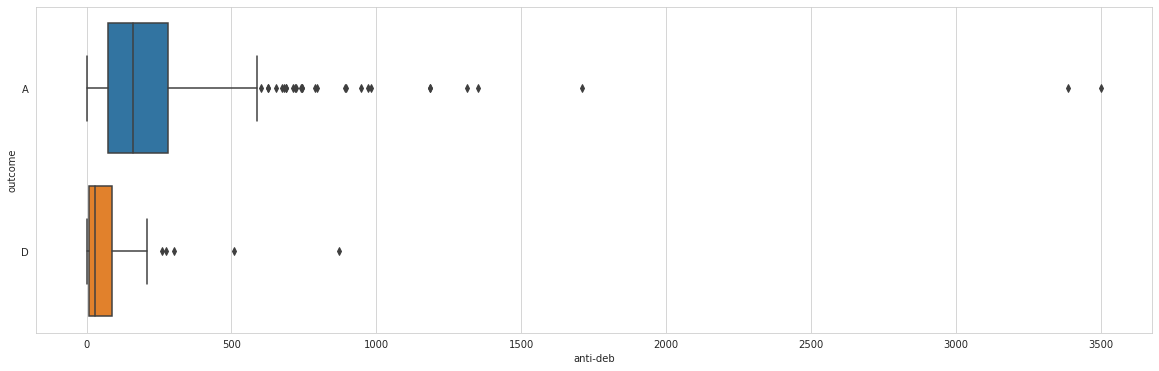

In [0]:
#1b). In the whole cohort, what is the median hours [IQR] from last debridement to last antibiotic given
# total.time_x = testmedt, _y = debridet

median_graph_threshold('anti-deb', 5000)
median_metics(lastdeb_lastanti,'anti-deb', 5000)

In [0]:
# filters the observations that are before the last date of operation 
# takes the closet date 
wbc_med = nsti_wbct.merge(testmedt[['patient.x', 'total.time','meds']], how = 'inner', on = 'patient.x')
wbc_med['difference'] = (wbc_med['specimenreceiveddttm'] - wbc_med['total.time'])
testwbc =  wbc_med.sort_values(by = ['patient.x', 'specimenreceiveddttm'], ascending = [True, True]).drop_duplicates(subset = ['patient.x'], keep = 'first')
wbc_med = wbc_med.merge(testwbc[['patient.x', 'specimenreceiveddttm']], how = 'left', on = 'patient.x')

wbc_med['baseline'] = wbc_med['specimenreceiveddttm_x'] - wbc_med['specimenreceiveddttm_y']
wbc_med['baseline'] = [ i.total_seconds() / 3600 for i in wbc_med['baseline']]


Overall: 12.59
Survivors: 11.36
Non-Survivors: 24.58


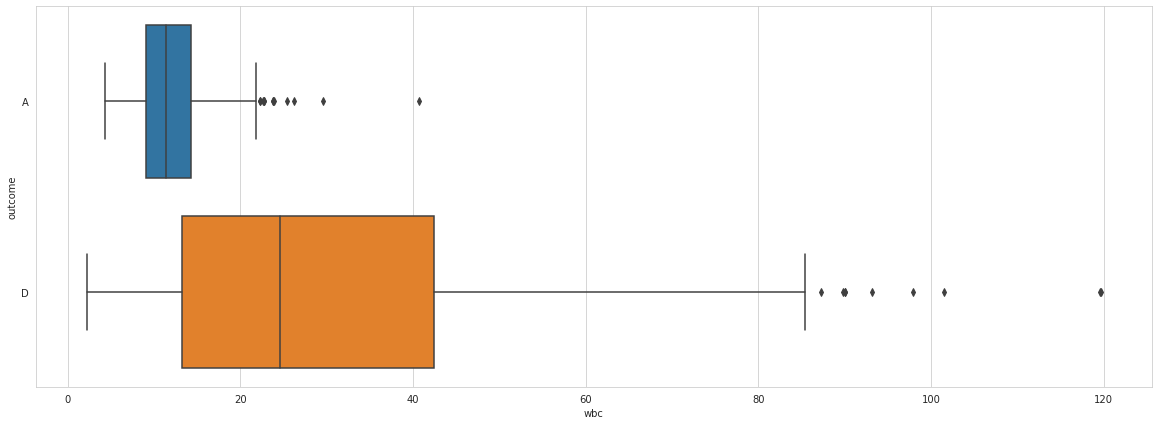

In [0]:
#1c). In the whole cohort, what is the median WBC [IQR] in the 24hrs before the last dose of antibiotic was given
wbc_24 = wbc_med[(wbc_med['difference'] < timedelta(days =0)) & (wbc_med['difference'] > timedelta(days =-1) ) ].sort_values(by = ['patient.x', 'difference'], ascending = [True, False]).reset_index()
wbc_24_base = wbc_24.merge(nstit[['patient.x', 'outcome']], how = 'inner', on = 'patient.x')

fig, ax = plt.subplots(figsize=(20,7))
sns.boxplot(ax = ax, data = wbc_24_base, x= 'wbc', y = 'outcome' )
ax.xaxis.grid(True)
print('Overall: ' + str(wbc_24_base['wbc'].median()))
print('Survivors: ' + str(wbc_24_base[wbc_24_base['outcome'] == 'A']['wbc'].median()))
print('Non-Survivors: ' + str(wbc_24_base[wbc_24_base['outcome'] == 'D']['wbc'].median()))

In [0]:
#1d) What proportion of people were still on antibiotics when their WBC drops <15, <12, <10
# Issues are when their wbc fluatates, could just use the last 15, 12, or 10 score they have 
def prop_patient(value):
    print('{0}: '.format(value) + str(len(nsti_wbct[nsti_wbct['wbc'] < value]['patient.x'].unique())/ len(nsti_wbct['patient.x'].unique())))

prop_patient(15)
prop_patient(12)
prop_patient(10)

15: 0.9351230425055929
12: 0.8948545861297539
10: 0.7897091722595079


Overall: 204.80833333333334
Not Bacteremia: 195.43333333333334
Bacteremia: 481.03333333333336

Overall: 138.425
Survivors: 159.43333333333334
Non-Survivors: 29.783333333333335



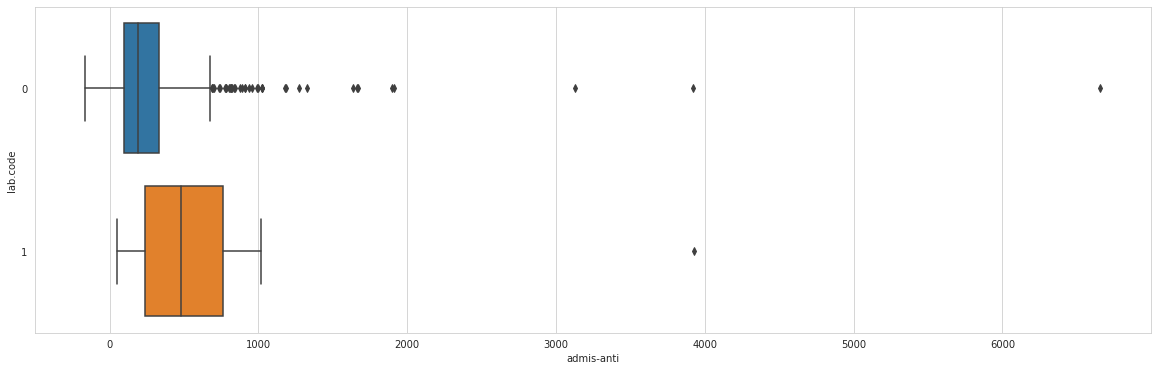

In [0]:
bac_last_deb = lastdeb_lastanti.merge(nsti_bact, how = 'left', on = 'patient.x')
bac_last_deb['lab.code'] = bac_last_deb['lab.code'].fillna(0).replace('BCULT', 1).astype('category')
def median_metics_bac(dataset, x, threshold):
  print("Overall: "+ str(dataset[(dataset[x] > 0) & (dataset[x] < threshold)][x].median()))
  print("Not Bacteremia: "+ str(dataset[(dataset[x] > 0) & (dataset[x] < threshold) & (dataset['lab.code'] == 0)][x].median()))
  print("Bacteremia: "+str(dataset[(dataset[x] > 0) & (dataset[x] < threshold) & (dataset['lab.code'] == 1)][x].median()))
  print()

# 1e. repeat a-d for bacteremia

#1a). Median duration of antibiotics (time from admission until last antibiotic is stopped)
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(ax = ax, data = bac_last_deb, x = 'admis-anti', y = 'lab.code')
median_metics_bac(bac_last_deb,'admis-anti',7000 )

#1b. Median duration between last antibiotic and last debridement
median_metics(bac_last_deb,'anti-deb', 7000)

Overall: 12.59
Surv - Not Bacteremia: 11.36
NonSurv - Bacteremia: 10.98
NonSurv - Not Bacteremia: 24.905
Surv - Bacteremia: 12.66


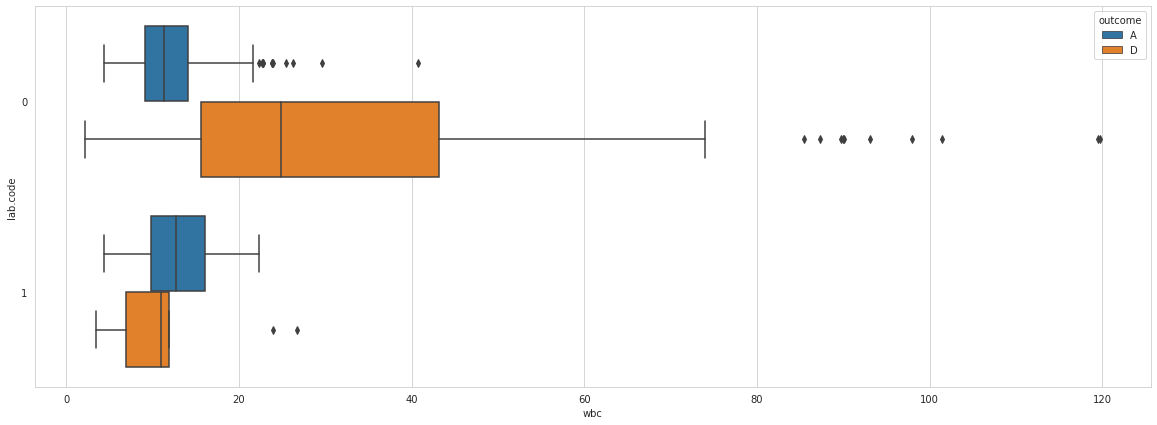

In [0]:
wbc_24_bac = wbc_med[(wbc_med['difference'] < timedelta(days =0)) & (wbc_med['difference'] > timedelta(days =-1) ) ].sort_values(by = ['patient.x', 'difference'], ascending = [True, False]).reset_index()
wbc_24_bac = wbc_24_bac.merge(bac_last_deb[['patient.x', 'lab.code']], how = 'inner', on = 'patient.x').merge(nstit[['patient.x', 'outcome']], how = 'inner', on = 'patient.x')

fig, ax = plt.subplots(figsize=(20,7))
sns.boxplot(ax = ax, data = wbc_24_bac, x= 'wbc', y = 'lab.code' ,hue ='outcome')
ax.xaxis.grid(True)
print('Overall: ' + str(wbc_24_bac['wbc'].median()))
print('Surv - Not Bacteremia: ' + str(wbc_24_bac[(wbc_24_bac['lab.code'] == 0) & (wbc_24_bac['outcome'] == 'A')]['wbc'].median()))
print('NonSurv - Bacteremia: ' + str(wbc_24_bac[(wbc_24_bac['lab.code'] == 1)& (wbc_24_bac['outcome'] == 'D')]['wbc'].median()))
print('NonSurv - Not Bacteremia: ' + str(wbc_24_bac[(wbc_24_bac['lab.code'] == 0)& (wbc_24_bac['outcome'] == 'D')]['wbc'].median()))
print('Surv - Bacteremia: ' + str(wbc_24_bac[(wbc_24_bac['lab.code'] == 1)& (wbc_24_bac['outcome'] == 'A')]['wbc'].median()))

In [0]:
# patients that are beyond the whisker and outliers 
lastdeb_lastanti[(lastdeb_lastanti['anti-deb'] < 0) | (lastdeb_lastanti['anti-deb'] > 600)]['study_id'].to_csv('outliers.csv')


## 2. Characterize initial antibiotics amongst EVERYONE: 


a). VANC + PCNG + CLIN + LEVO
OR
b). VANC + PCNG + CLIN + GENT
OR
c). VANC + PIPE + CLIN

in the first 24 hours of admission?

In [0]:
#2a sns.distplot(nsti_medt[nsti_medt['admis.diff'] > timedelta(seconds = 0)]['admis.diff'].dt.seconds / 3600)
# nsti_medt.merge(nstit[['patient.x', 'perineum.involved']] , how= 'inner', on = 'patient.x')
testmedtpivot = nsti_medt[(nsti_medt['admis.diff'] > timedelta(seconds = 0)) & (nsti_medt['admis.diff'] < timedelta(days = 1))].sort_values(by = ['patient.x', 'meds'])
testmedtpivot['value'] = 1
testmedtpivot = testmedtpivot[['patient.x', 'meds', 'value']].drop_duplicates().pivot(index = 'patient.x', columns = 'meds', values = 'value').merge(nstit[['patient.x', 'perineum.involved']] , how= 'inner', on = 'patient.x')
testmedtpivot = testmedtpivot.fillna(0)
#testmedtpivot['study_id'] = testmedtpivot.index

In [0]:
print('VANC, PCNG, CLIN, LEVO: ' + str(len(testmedtpivot[(testmedtpivot['CLIN'] == 1) &
                                          (testmedtpivot['VANC'] == 1) &
                                          (testmedtpivot['PCNG'] == 1) &
                                          (testmedtpivot['LEVO'] == 1) ]) / len(testmedtpivot)))
print('VANC, PCNG, CLIN, GENT: ' + str(len(testmedtpivot[(testmedtpivot['PCNG'] == 1) &
                                      (testmedtpivot['VANC'] == 1) &
                                      (testmedtpivot['CLIN'] == 1) &
                                      (testmedtpivot['GENT'] == 1) ]) / len(testmedtpivot)))
print('VANC, CLIN, PIPE: '+ str(len(testmedtpivot[(testmedtpivot['CLIN'] == 1) &
                                (testmedtpivot['VANC'] == 1) &
                                (testmedtpivot['PIPE'] == 1)]) / len(testmedtpivot)))
print('VANC, CLIN, LEVO: '+ str(len(testmedtpivot[(testmedtpivot['CLIN'] == 1) &
                                (testmedtpivot['VANC'] == 1) &
                                (testmedtpivot['LEVO'] == 1)]) / len(testmedtpivot)))
print('VANC, MERO, CLIN, GENT: ' + str(len(testmedtpivot[(testmedtpivot['MERO'] == 1) &
                                      (testmedtpivot['VANC'] == 1) &
                                      (testmedtpivot['CLIN'] == 1) &
                                      (testmedtpivot['GENT'] == 1) ]) / len(testmedtpivot)))
print('VANC, MERO, CLIN, LEVO: ' + str(len(testmedtpivot[(testmedtpivot['MERO'] == 1) &
                                      (testmedtpivot['VANC'] == 1) &
                                      (testmedtpivot['CLIN'] == 1) &
                                      (testmedtpivot['GENT'] == 1) ]) / len(testmedtpivot)))

print('VANC, MERO, CLIN, LEVO: 'str(len(testmedtpivot[(testmedtpivot['VANC'] == 1) &
                                        (testmedtpivot['CLIN'] == 1)  & 
                                        (((testmedtpivot['PCNG'] == 1) & 
                                          ((testmedtpivot['LEVO'] == 1) | (testmedtpivot['GENT'] == 1))) | (testmedtpivot['PIPE'] == 1) )]) / len(testmedtpivot)))

VANC, PCNG, CLIN, LEVO: 0.49257425742574257
VANC, PCNG, CLIN, GENT: 0.027227722772277228
VANC, CLIN, PIPE: 0.2896039603960396
VANC, CLIN, LEVO: 0.5891089108910891
VANC, MERO, CLIN, GENT: 0.0024752475247524753
VANC, MERO, CLIN, LEVO: 0.0024752475247524753
0.7277227722772277


In [0]:
#2a2 
per_inv_medt = testmedtpivot[testmedtpivot['perineum.involved'] == 1]
print(len(per_inv_medt[(per_inv_medt['CLIN'] == 1) &(per_inv_medt['VANC'] == 1) &(per_inv_medt['PCNG'] == 1) &(per_inv_medt['LEVO'] == 1)  ]) / len(per_inv_medt))
print(len(per_inv_medt[(per_inv_medt['PCNG'] == 1) &(per_inv_medt['VANC'] == 1) &(per_inv_medt['CLIN'] == 1) &(per_inv_medt['GENT'] == 1) ]) / len(per_inv_medt))
print(len(per_inv_medt[(per_inv_medt['CLIN'] == 1) &(per_inv_medt['VANC'] == 1) &(per_inv_medt['PIPE'] == 1)]) / len(per_inv_medt))
print(len(per_inv_medt[(per_inv_medt['VANC'] == 1) &(per_inv_medt['CLIN'] == 1)  & (((per_inv_medt['PCNG'] == 1) & ((per_inv_medt['LEVO'] == 1) | (per_inv_medt['GENT'] == 1))) | (per_inv_medt['PIPE'] == 1) )]) / len(per_inv_medt))

In [0]:
#2b Median number of different antibiotics given per hospital day
# Track the base of their admission then subtract each following time point then do a mode of the day 
nsti_medt['day'] = nsti_medt['admis.diff'] // np.timedelta64(1, 'D') 

for day in range(1,max(nsti_medt['day'])):
  day_data = nsti_medt[nsti_medt['day'] == day]
  for patient in day_data['patient.x'].unique():
    


In [0]:
day = 1
nsti_medt[nsti_medt['day'] == day]

In [0]:
test1.first()

In [0]:
#https://stackoverflow.com/questions/35268817/unique-combinations-of-values-in-selected-columns-in-pandas-data-frame-and-count
# categorical breakdown with count 
testmedtpivot['patient.x'] = testmedtpivot.index
testmedtpivot.groupby(['CIPR', 'CLIN', 'GENT', 'LEVO', 'MERO', 'METR', 'PCNG', 'PIPE', 'VANC']).size().reset_index().rename(columns={0:'count'}).to_csv('ven_med.csv')

In [0]:
# export to R for upstart diagram 
testmedtpivot= testmedtpivot[['patient.x', 'meds', 'value']].drop_duplicates().pivot(index = 'patient.x', columns = 'meds', values = 'value')
testmedtpivot = testmedtpivot.fillna(0)
testmedtpivot.to_csv('ven_med.csv')

In [0]:
nsti_medt = nsti_medt.merge(nstit[['patient', 'admit.x']], how = 'left', left_on = 'study_id', right_on = 'patient')

In [0]:
#wbc_med[wbc_med['baseline'] != timedelta(0,0)].sort_values(by = ['baseline'])['baseline'].total_seconds()
wbc_med= wbc_med.merge(nstit[['patient', 'outcome']], how = 'left', left_on= 'study_id', right_on= 'patient')

In [0]:
nsti_merge = test[['patient', 'observationvalue', 'observationdttm_x', 'difference','meds', 'total.time']].merge(nstit, how = "left", on = "patient")

In [0]:
# shows the breakdown of outcome with observation value 
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(ax = ax, data = nsti_merge,x = 'observationvalue', y = 'outcome', hue = 'race')
ax.xaxis.grid(True)

In [0]:
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(ax = ax, data = nsti_merge,x = 'observationvalue', y = 'meds', hue = 'outcome')
ax.xaxis.grid(True)

In [0]:
# shows the breakdown of outcome with observation value 
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(ax = ax, data = nsti_merge,x = 'observationvalue', y = 'sex', hue = 'outcome')
ax.xaxis.grid(True)

In [0]:
# shows the breakdown of outcome with observation value 
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(ax = ax, data = nsti_merge,x = 'debride.count', y = 'observationvalue', hue = 'outcome')
ax.xaxis.grid(True)

In [0]:
# shows the breakdown of meds and observation value 
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(ax = ax, data = nsti_merge,x = 'observationvalue', y = 'outcome', hue = 'meds')
ax.xaxis.grid(True)

In [0]:
#
fig, ax = plt.subplots(figsize=(20,6))
sns.distplot( nsti_merge[nsti_merge['outcome'] == 'D']['difference'].dt.seconds , bins = 15)
ax.xaxis.grid(True)

#nsti_merge['diff_hours'] = nsti_merge['difference'].dt.seconds / 3600

In [0]:
fig, ax = plt.subplots(figsize=(20,6))
sns.distplot( wbc_med[wbc_med['baseline'] < 1000]['baseline'] , bins = 1000)
ax.xaxis.grid(True)

In [0]:
#test.head()
nsti_merge#[nsti_merge['outcome'] == "D"]
nsti_merge['outcome']  = (nsti_merge['outcome'] == 'A')*1
#wbc_med.head()

In [0]:
#fig, ax = plt.subplots(figsize=(18,11))
#sns.regplot(x = 'observationvalue', y = 'outcome', data = nsti_merge, logistic = True, ax = ax)
sns.lmplot(x = 'observationvalue', y = 'outcome', data = nsti_merge, logistic = True, height = 10)

In [0]:
#fig, ax = plt.subplots(figsize=(60,11))
#g = sns.FacetGrid(height = 10,  data = wbc_med[wbc_med['baseline'] < 1000], col = 'outcome')
#g = g.map(sns.lineplot, 'baseline','observationvalue')

sns.lmplot( x =  'baseline',y = 'observationvalue', data = wbc_med[wbc_med['patient_x'] < 10][wbc_med['baseline'] < 1000], hue = 'outcome', height = 5, legend = False, row = 'patient_x')
#sns.lineplot(ax = ax, data = wbc_med[wbc_med['patient_x'] == 3],x = 'baseline', y = 'observationvalue', hue = 'outcome')
#ax.xaxis.grid(True)


## Creating a proxy dataset for just total time andy study id

In [0]:
# makes it so there isn't any duplicate 
nsti_med_max = nsti_medt[['study_id', 'total.time']]
nsti_med_max = nsti_med_max.drop_duplicates(subset = ['study_id', 'total.time'], keep = 'first')
idx = nsti_med_max.groupby(['study_id'])['total.time'].transform(max) == nsti_med_max['total.time']
       
nsti_med_max = nsti_med_max[idx]

# [nstit][nsti_debridet] Merger of nsti demo and debride data

In [0]:
# Merges the debride and nsti df to one 
nsti_full = nstit.merge(nsti_debridet, left_on= "patient", right_on = "study_id")

## Removing featuresfrom nsti_full

Removes Cost, deb, and rec data from the overall dataset while keeping it as a seperate dataset with identifiers 

- debisolate
- recisolate 

In [0]:
#Remove cost data
listcost = list(i for i in list(nsti_full.columns) if not (re.search(r'(costs)',i)))
nsti_full = nsti_full[listcost]

# removing the deb data 
listdeb = list(i for i in list(nsti_full.columns) if (re.search(r'^(deb)',i)))
debisolate = nsti_full[['patient']+listdeb]
nsti_full.drop(listdeb, axis = 1, inplace = True)

# removin the rec data
listrec = list(i for i in list(nsti_full.columns) if (re.search(r'^(rec)',i)))
recisolate = nsti_full[['patient']+listrec]
nsti_full.drop(listrec, axis = 1, inplace = True)

## Formatting the date in [nsti_full] and pulling the target variable

In [0]:
# Removing nulls
nsti_full = nsti_full[nsti_full['minutes.from'] != "NA"]

#Formating string dates to timedate type
nsti_full['admit.x'] = pd.to_datetime(nsti_full['admit.x'], format = '%m/%d/%Y')
nsti_full['discharge'] = pd.to_datetime(nsti_full['discharge'], format = '%m/%d/%Y')
nsti_full['minutes.from'] = pd.to_numeric(nsti_full['minutes.from']).apply(lambda x: timedelta(minutes = x))

# Making a feature that combines the minutes from {admit to last debridement} 
# and the date of the admission to get rough time of the actual time date of debridement
nsti_full['admittodeb'] = nsti_full['admit.x'] + nsti_full['minutes.from']

## TASK: Find the difference in time between the last debridement and last medication 

- Status: Completed 

- Notes: 

The main issue is that there are negative values when it should be mostly positive.

It was noted that for some of the patients, incomplete data as well as wrong indication towards data usage.

Manual picking is needed 

- Updates: Need to work off of the new dataset

In [0]:
# making sure that the dataset only has positive variables 
nsti_complete = nsti_full.merge(nsti_med_max, left_on = 'patient', right_on= 'study_id' )

# Creating a new feature in the difference in hours 
nsti_complete['debtomed'] = (nsti_complete['total.time'] - nsti_complete['admittodeb']) / np.timedelta64(1, 'h') 
nsti_complete = nsti_complete.loc[nsti_complete['debtomed'] >= 0.0]
nsti_complete = nsti_complete[nsti_complete.columns[~nsti_complete.columns.str.contains('minutes')]]

# Cleaning up the dataset by eliminating some of the extra features 
nsti_complete.drop(['discharge','sex','admit.x','location.code.1', 'location.code.2','icd.10.code..1', 'icd.10..1.description','icd.10.code..2','icd10..2.descrition','admit.y',
                    'insure','insure_type','admit.date.x.x','dc_date','transfer_y','dc.dispo','admittodeb', 'total.time','study_id_y','study_id_x','transfer_x'], axis = 1, inplace = True)

# Model creation 

Under construction need some more work and understand of the data 

# Feature encoding 

Need to figure out what exactly to encode some of the features 

In [0]:
nsti_complete_filter = nsti_complete[nsti_complete['debtomed'] <5000]

binary_change = {"outcome": {"A": 1, "D": 0}}

nsti_complete_filter.replace(binary_change, inplace=True)
nsti_complete_filter.head()

#https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
nsti_complete_filter = pd.get_dummies(nsti_complete_filter, columns =['mechanism.of.infection', 'race'])

dummy_code = pd.get_dummies(nsti_complete_filter['comorbid.codes'].str.split(';').apply(pd.Series).stack()).sum(level=0)
dummy_region = pd.get_dummies(nsti_complete_filter['region'].str.split('; ').apply(pd.Series).stack()).sum(level=0)
df_dummyfull = pd.concat([dummy_code,dummy_region],axis=1,join = 'inner')
nsti_new = pd.concat([nsti_complete_filter, dummy_region], axis = 1)
nsti_new.drop(['region','patient','comorbid.codes','co.morbids','icu.los','icu.hours','hosp.los', 'vent.days'], axis = 1, inplace = True)

Converting to all floats 

In [0]:
# see how many na are there
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(nsti_new.dropna().isnull(), cbar=False, cmap="YlGnBu_r")
fig.patch.set_facecolor('xkcd:mint green')
plt.show()

#nsti_new.dropna(axis=1,how='all')

In [0]:
corr = nsti_new.corr()

In [0]:
fig, ax = plt.subplots(figsize=(20,14))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap = "PiYG")


Doesn't seem to be that much correlation for our target 

Feature selection

In [0]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier

import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

nsti_new = nsti_new.dropna()
y = nsti_new['debtomed']
y = y.astype('int')
nsti_new.drop(['debtomed','unnamed:_0'], axis = 1, inplace = True)
X = nsti_new

# Univariate selection
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

#tasks: Need to convert other strings to numerical or numeraid

In [0]:
model = LinearRegression().fit(X[['age','race_','mechanism.of.infection_BURN', 'cauti','vap','bleeding','pe','unplanned.ett','unplanned.or','cpr']], y)

r_sq = model.score(X[['age','race_','mechanism.of.infection_BURN', 'cauti','vap','bleeding','pe','unplanned.ett','unplanned.or','cpr']], y)
print('coefficient of determination:', r_sq)


Seeing as a linear regression doesn't really help with this